# 画像メディア工学１３回目

## 13. テンプレートマッチング


### ライブラリの読み込み

In [1]:
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, rc

### 本ファイルで用いる画像をColabへアップロード

以下の画像をColabにアップロード．

対象画像（小）：https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img10.png

テンプレート（小）：https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img10_template.png

対象画像（大）：https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img11.jpg

テンプレート（大）：https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img11_template.jpg

演習用対象画像：https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img12.jpg

演習用テンプレート1：https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img12_temp1.jpg

演習用テンプレート2：https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img12_temp2.jpg

In [2]:
!wget https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img10.png -O img10.png
!wget https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img10_template.png  -O img10_template.png
!wget https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img11.jpg -O img11.jpg
!wget https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img11_template.jpg -O img11_template.jpg
!wget https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img12.jpg -O img12.jpg
!wget https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img12_temp1.jpg -O img12_temp1.jpg
!wget https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img12_temp2.jpg -O img12_temp2.jpg

--2023-01-21 06:19:50--  https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img10.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 804 [image/png]
Saving to: ‘img10.png’

img10.png           100%[===================>]     804  --.-KB/s    in 0s      

2023-01-21 06:19:50 (56.0 MB/s) - ‘img10.png’ saved [804/804]

--2023-01-21 06:19:50--  https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img10_template.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 184 [image/png]
Saving to: ‘img10

### ステレオマッチング用の画像

探索対象の画像とテンプレート画像を２セット（大画像と小画像）を用意している．

まず，小画像（img10.png, img10_template.png）の方を実行し，

その後，大画像（img11.jpg, img11_template.jpg）の方も実行してみてください．

（目視でのマッチングは困難なはずです）

* 小画像

対象画像 | テンプレート
:---: | :---: 
<img src="https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img10.png" width="100px">|<img src="https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img10_template.png" width="20px">

* 大画像

対象画像 | テンプレート
:---: | :---:
<img src="https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img11.jpg" width="480px">|<img src="https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img11_template.jpg" width="32px">


元画像はカラー画像であるが，ここではモノクロ画像に変換してからテンプレートマッチングを行う．

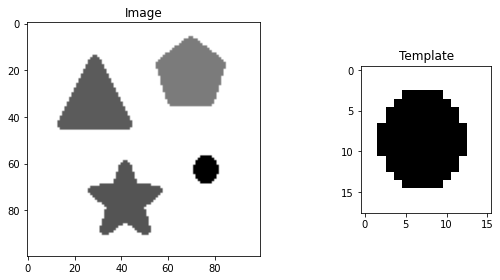

In [3]:
# カラー画像の読み込み　（小画像と大画像を切り替え）
img_col = cv2.imread('img10.png')
img_temp_col = cv2.imread('img10_template.png')
# img_col = cv2.imread('img11.jpg')
# img_temp_col = cv2.imread('img11_template.jpg')

# RGB順の変換
img_col = cv2.cvtColor(img_col, cv2.COLOR_BGR2RGB)
img_temp_col = cv2.cvtColor(img_temp_col, cv2.COLOR_BGR2RGB)

# モノクロ画像への変換
img = cv2.cvtColor(img_col, cv2.COLOR_RGB2GRAY)
img_temp = cv2.cvtColor(img_temp_col, cv2.COLOR_RGB2GRAY)

# 画像・テンプレートサイズ
h, w = img.shape
th, tw = img_temp.shape

# 読み込んだ画像の表示
fig = plt.figure(figsize=(8,4))
ax1 = plt.subplot2grid((1, 4), (0, 0), colspan=3)
plt.imshow(img, cmap='gray', vmin = 0, vmax = 255);
ax1.set_title("Image")
ax2 = plt.subplot2grid((1, 4), (0, 3))
plt.imshow(img_temp, cmap='gray', vmin = 0, vmax = 255);
ax2.set_title("Template")

fig.tight_layout()
fig.show()

### テンプレートマッチングの関数の定義
ここでは，類似度（相違度）をSSD (Sum of Squiared Difference，差の二乗和) で計算している．

（相違度が低ければ類似度は高いことを意味する）

In [4]:
def matchTemplate(img, img_temp):
  h, w = img.shape
  th, tw = img_temp.shape

  img_f = img.astype(np.float)
  img_temp_f = img_temp.astype(np.float)
  ssd_results = np.zeros((h-th+1,w-tw+1),dtype=np.float32)

  for y in range(w-tw+1):
    for x in range(h-th+1):
      for j in range(tw):
        for i in range(th):
          # 類似度の計算
          diff = img_f[x+i, y+j] - img_temp_f[i, j]
          ssd_results[x, y] += diff*diff
          
  return ssd_results  

### テンプレートマッチングの実行・類似度（相違度）の計算
小さな画像の場合は，上記の自作テンプレートマッチング関数を用いても問題ない．

しかし大きな画像に対して自作関数を用いると，処理に長時間かかってしまう（４重ループになっており，特に高速化の工夫をしていないため）．

そのため，実際にテンプレートマッチングを行う場合には，OpenCVで提供されているテンプレートマッチング関数``cv2.matchTemplate()``を用いると良い（第３引数の``cv2.TM_SQDIFF``は差の２乗和（SSD）を計算するという意味）．


In [5]:
#matching_res = matchTemplate(img, img_temp) # 上述の自作関数でテンプレートマッチング
matching_res = cv2.matchTemplate(img, img_temp, cv2.TM_SQDIFF) # OpenCVのテンプレートマッチング関数

### テンプレートマッチング結果の表示
疑似カラー画像を用いて，テンプレートマッチング結果を描画する．青は相違度が低いことを意味し，赤は相違度が高いことを意味する．


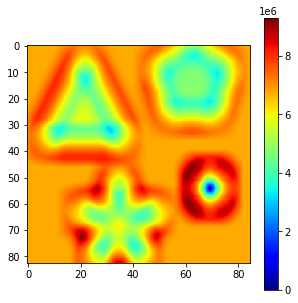

In [6]:
fig = plt.figure(figsize=(5,5))
im = plt.imshow(matching_res, cmap="jet")
fig.colorbar(im)

この結果を３次元プロットで表示すると

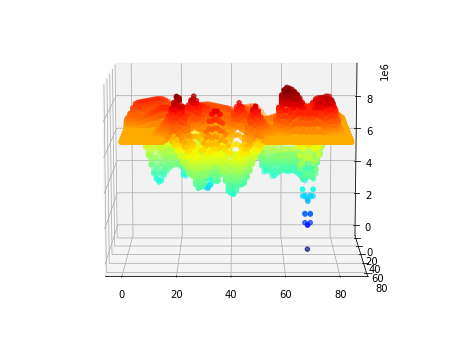

In [7]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(projection='3d')
ax.invert_xaxis()
ax.view_init(elev=10., azim=90.)

w = np.arange(matching_res.shape[0])
h = np.arange(matching_res.shape[1])
X, Y = np.meshgrid(h, w)

ax.scatter(X, Y, matching_res, c = matching_res, cmap = 'jet')

### テンプレートマッチング結果の描画
相違度をSSDで計算した場合，相違度が最小の場所がテンプレート位置となる．

ここでは，最小場所の探索に，OpenCVの関数``cv2.minMaxLoc(matching_res)``を用いている．

最後に，最小場所に赤枠を描画している．テンプレート位置に赤枠が描画されていることがわかる．

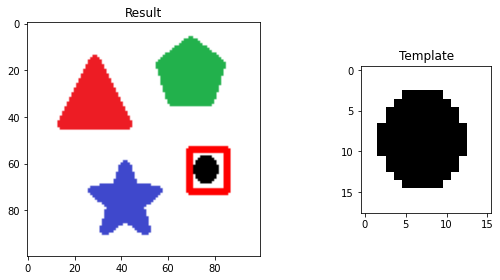

In [8]:
# マッチング結果の最大値とその場所，最小値とその場所を取得
min_val, max_val, min_pt, max_pt = cv2.minMaxLoc(matching_res)

# 相違度最大の場所に赤枠を描画
cv2.rectangle(img_col, min_pt, (min_pt[0] + tw, min_pt[1] + th), ( 255, 0, 0), 2)

# 結果とテンプレート画像を表示
fig = plt.figure(figsize=(8,4))
ax1 = plt.subplot2grid((1, 4), (0, 0), colspan=3)
plt.imshow(img_col, vmin = 0, vmax = 255);
ax1.set_title("Result")
ax2 = plt.subplot2grid((1, 4), (0, 3))
plt.imshow(img_temp_col, vmin = 0, vmax = 255);
ax2.set_title("Template")

fig.tight_layout()
fig.show()


## 課題：画像中にテンプレートが含まれない場合

以下のような対象画像に対して，２種類のテンプレート画像のマッチングを行う場合を考える．テンプレート１は対象画像に含まれるが，テンプレート２は対象画像に含まれない．こういった場合，単純に最小の場所をテンプレート位置としたのでは正しい結果とはならない．

こういった場合，どういった処理を追加する必要があるか，考えてみてください．

対象画像 | テンプレート1 | テンプレート2
:---: | :---: | :---:
<img src="https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img12.jpg" width="320px">|<img src="https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img12_temp1.jpg" width="86px">|<img src="https://raw.githubusercontent.com/yamazoe/ImageMediaProcessing/main/img/img12_temp2.jpg" width="86px">

### 画像の読み込みと相違度の計算


In [9]:
# カラー画像の読み込み
img_col = cv2.imread('img12.jpg')
img_temp1_col = cv2.imread('img12_temp1.jpg')
img_temp2_col = cv2.imread('img12_temp2.jpg')

img_col = cv2.cvtColor(img_col, cv2.COLOR_BGR2RGB)
img_temp1_col = cv2.cvtColor(img_temp1_col, cv2.COLOR_BGR2RGB)
img_temp2_col = cv2.cvtColor(img_temp2_col, cv2.COLOR_BGR2RGB)

img = cv2.cvtColor(img_col, cv2.COLOR_RGB2GRAY)
img_temp1 = cv2.cvtColor(img_temp1_col, cv2.COLOR_RGB2GRAY)
img_temp2 = cv2.cvtColor(img_temp2_col, cv2.COLOR_RGB2GRAY)

matching_res_1 = cv2.matchTemplate(img, img_temp1, cv2.TM_SQDIFF)
matching_res_2 = cv2.matchTemplate(img, img_temp2, cv2.TM_SQDIFF)

### テンプレートマッチング結果の描画
マッチング結果を描画する．テンプレート１の結果は赤枠で，テンプレート２の結果は緑枠で描画している．

図からわかるように，テンプレート２の結果（緑枠）は，相違度が最小の場所に描画したにもかかわらず，正しい結果とはなっていない．

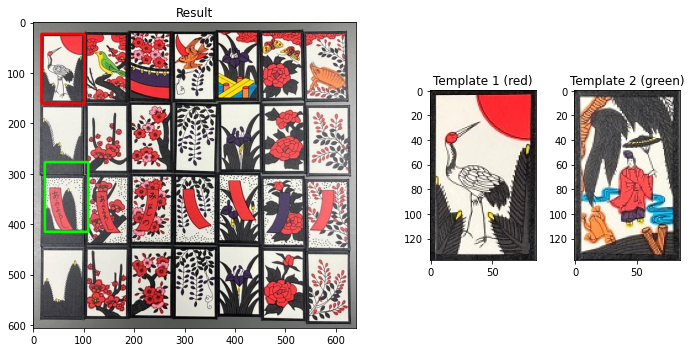

In [10]:
# 画像・テンプレートサイズ
h, w = img.shape
th, tw = img_temp1.shape

# マッチング結果の最大値とその場所，最小値とその場所を取得
min_val1, max_val1, min_pt1, max_pt1 = cv2.minMaxLoc(matching_res_1)
min_val2, max_val2, min_pt2, max_pt2 = cv2.minMaxLoc(matching_res_2)

# 相違度最大の場所に赤枠(temp1)と緑枠(temp2)を描画
cv2.rectangle(img_col, min_pt1, (min_pt1[0] + tw, min_pt1[1] + th), ( 255, 0, 0), 4)
cv2.rectangle(img_col, min_pt2, (min_pt2[0] + tw, min_pt2[1] + th), ( 0, 255, 0), 4)

# 結果とテンプレート画像を表示
fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=3)
plt.imshow(img_col, vmin = 0, vmax = 255);
ax1.set_title("Result")
ax2 = plt.subplot2grid((1, 5), (0, 3))
plt.imshow(img_temp1_col, vmin = 0, vmax = 255);
ax2.set_title("Template 1 (red)")
ax2 = plt.subplot2grid((1, 5), (0, 4))
plt.imshow(img_temp2_col, vmin = 0, vmax = 255);
ax2.set_title("Template 2 (green)")
fig.tight_layout()
fig.show()


### 相違度の計算結果の描画
SSDによる相違度の計算結果をプロットする．左がテンプレート１のマッチング結果，右がテンプレート２のマッチング結果である．

これらも参考に，対策を考えてみてください．

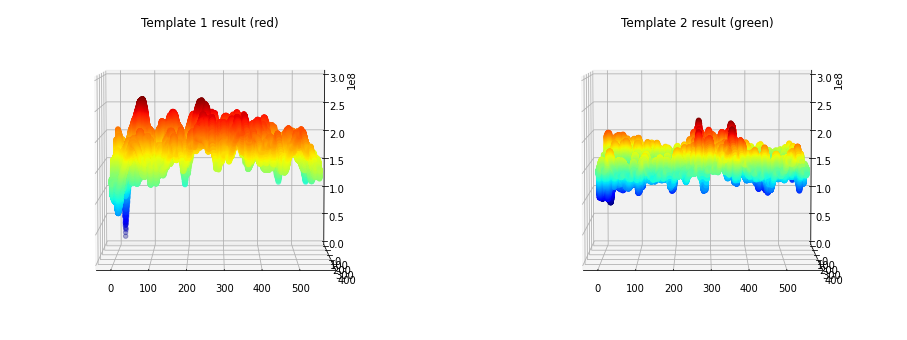

In [11]:
fig = plt.figure(figsize=(16,6))

w = np.arange(matching_res_1.shape[0])
h = np.arange(matching_res_1.shape[1])
X, Y = np.meshgrid(h, w)

ax = fig.add_subplot(1,2,1,projection='3d')
ax.invert_xaxis()
ax.view_init(elev=5., azim=90.)
ax.set_zlim((0,3e8))
ax.set_title("Template 1 result (red)")
ax.scatter(X, Y, matching_res_1, c = matching_res_1, cmap = 'jet')

ax = fig.add_subplot(1,2,2,projection='3d')
ax.invert_xaxis()
ax.view_init(elev=5., azim=90.)
ax.set_zlim((0,3e8))
ax.set_title("Template 2 result (green)")
ax.scatter(X, Y, matching_res_2, c = matching_res_2, cmap = 'jet')